# Prueba técnica TusDatos.co


En este cuaderno se presentan los resultados obtenidos en la prueba técnica asignada con los comentarios y el análisis respectivo. Cabe anotar que aunque todos los numerales que indicaba la prueba se tuvieron el cuenta, el orden y las numeraciones pueden ser distintas.

## 1. Importamos las librerías a utilizar y cargamos los datos  

A continuación importamos las librerías que se utilizaron para el desarrollo de esta prueba.

In [179]:
# Importamos las librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
%matplotlib inline 

In [2]:
#Cargamos la base de datos asignada
data = pd.read_csv('Cruceros.csv')

In [147]:
#Verificamos las dimensiones(Instancias y características)
print(data.shape[0])#Muestras
print(data.shape[1])#Características

158
9


In [4]:
#Visualizamos las primeras 5 muestras para familiarizarnos con la estructura de los datos
data.head()

,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
0,Journey,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
1,Quest,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
2,Celebration,Carnival,26,47.262,14.86,7.22,7.43,31.80,6.70
3,Conquest,Carnival,11,110.000,29.74,9.53,14.88,36.99,19.10
4,Destiny,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.00


In [5]:
# Verificamos el formato de cada columna y visualizamos si existen o no datos nulos. 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ship_name          158 non-null    object 
 1   Cruise_line        158 non-null    object 
 2   Age                158 non-null    int64  
 3   Tonnage            158 non-null    float64
 4   passengers         158 non-null    float64
 5   length             158 non-null    float64
 6   cabins             158 non-null    float64
 7   passenger_density  158 non-null    float64
 8   crew               158 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 11.2+ KB


* De la celda anterior podemos observar que de las 9 columnas que consta la base de datos, 7 son variables numéricas y 2 son variables categóricas. 

* También es importante anotar que la base de datos está bien estructurada y además no posee ninguna entrada nula.
* De acuerdo con el problema planteado, la variable a predecir (salida) es la columna $\texttt{'crew'}$.
* A continuación se visualizan de manera individual las dos variables categóricas.

In [6]:
#Visualizamos la variable 'Ship_name'
data['Ship_name'].value_counts()

Spirit          4
Legend          3
Star            3
Rhapsody        2
Mariner         2
               ..
Serena          1
Romantica       1
Mediterranea    1
Marina          1
Surf            1
Name: Ship_name, Length: 138, dtype: int64

In [149]:
#Visualizamos la variable 'Cruise_line'
data['Cruise_line'].value_counts()

Royal_Caribbean      23
Carnival             22
Princess             17
Holland_American     14
Norwegian            13
Costa                11
Celebrity            10
MSC                   8
Star                  6
P&O                   6
Regent_Seven_Seas     5
Silversea             4
Oceania               3
Seabourn              3
Windstar              3
Cunard                3
Disney                2
Crystal               2
Azamara               2
Orient                1
Name: Cruise_line, dtype: int64

# 2. Análisis exploratorio

En esta sesión procedemos a observar los datos con más profundidad, a partir de gráficos que permitan extraer información relevante y momentos estadísticos.

En la siguiente celda podemos observar algunas medidas estadísticas que nos permiten tener una idea más clara de las distribuciones de los datos. Como primera observación, podemos afirmar que no existen datos atípicos, pues cada muestra se encuentra en escalas similares de acuerdo a la información que nos entrega los extremos y las medias.

In [8]:
#Calculamos algunos momentos estadísticos comunes
data.describe()

,Age,Tonnage,passengers,length,cabins,passenger_density,crew
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,15.689873,71.284671,18.457405,8.130633,8.830000,39.900949,7.794177
std,7.615691,37.229540,9.677095,1.793474,4.471417,8.639217,3.503487
min,4.000000,2.329000,0.660000,2.790000,0.330000,17.700000,0.590000
25%,10.000000,46.013000,12.535000,7.100000,6.132500,34.570000,5.480000
50%,14.000000,71.899000,19.500000,8.555000,9.570000,39.085000,8.150000
75%,20.000000,90.772500,24.845000,9.510000,10.885000,44.185000,9.990000
max,48.000000,220.000000,54.000000,11.820000,27.000000,71.430000,21.000000


A continuación procedemos a representar gráficamente cada una de las columnas de nuestro dataset. Para esto utilizamos el método $\texttt{hist}$ de la librería $\texttt{pandas}$, la cual nos permite construir histogramas como una representación no paramétrica de las funciones de distribución de los datos. 

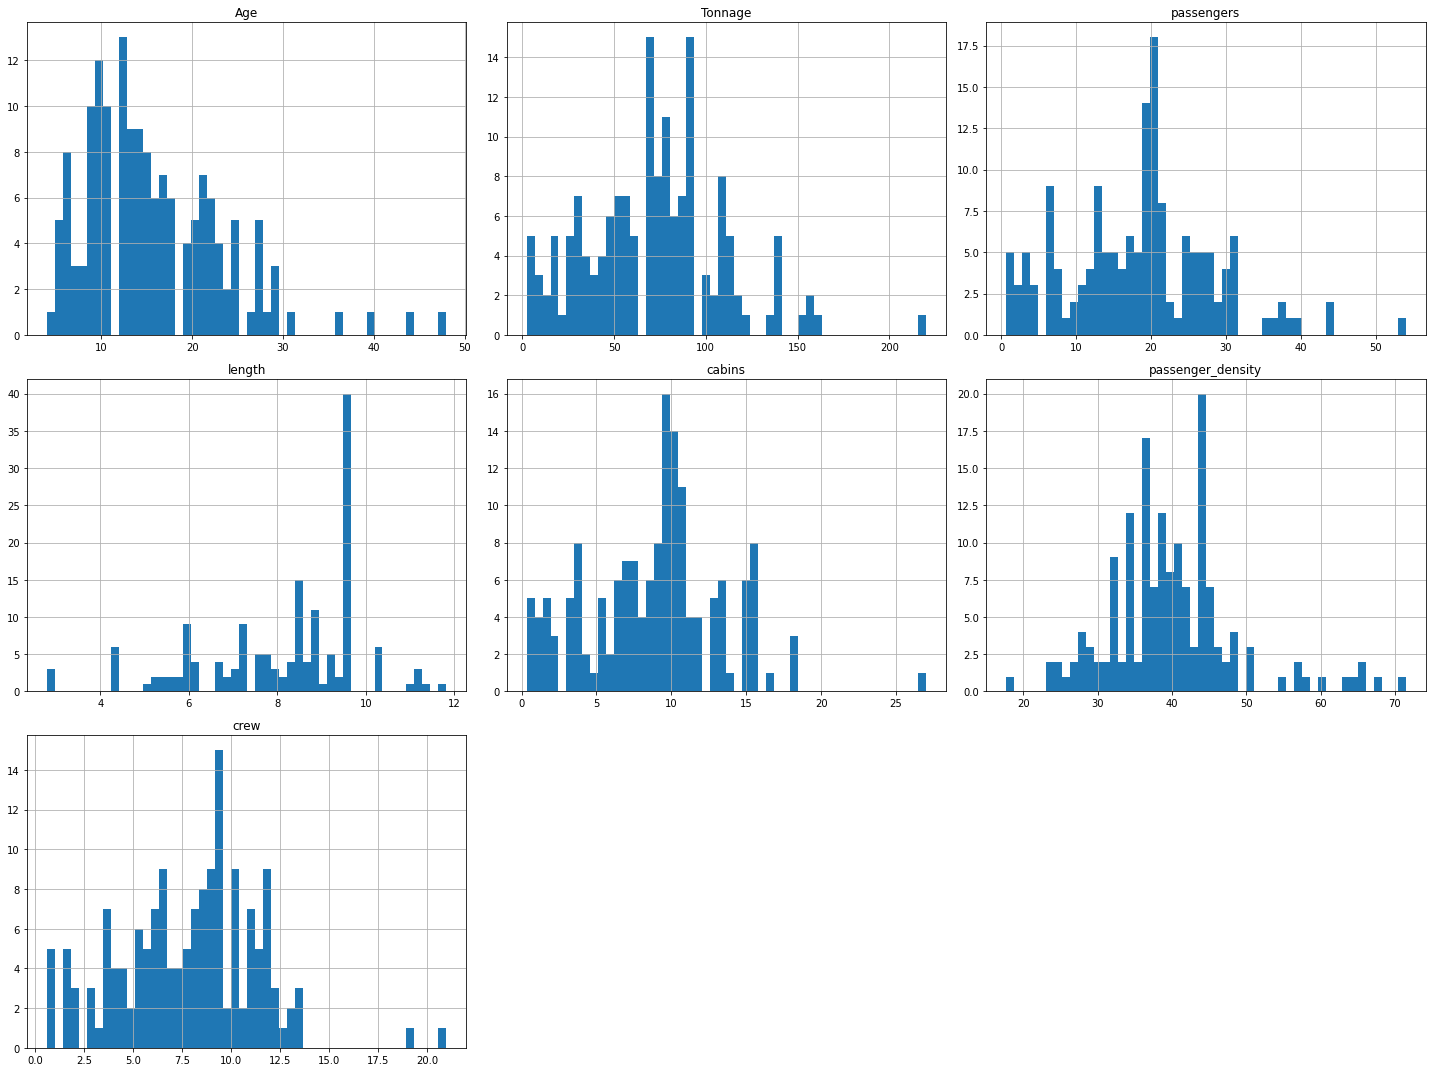

In [9]:
#Distribuciones de las características 
data.hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

*De las anteriores figuras podemos corroborar gráficamente lo afirmado anteriormente con respecto a la no existencia de datos outliers en nuestro set. Además podemos notar que por lo general las distribuciones tienden a ser unimodales (un solo pico) y en algunas se presenta cierta simetría.

Con el fin de estudiar la relación que existe en las características de nuestros datos, procedemos a calcular la matriz de coeficiente de correlación de Pearson, el cual nos da información acerca de la dependencia lineal que existe entre las variables y la salida que queremos predecir. El coeficiente de Pearson es un número real entre -1 y 1, los valores positivos nos dan razon de correlaciones positivas, los negativos de dependencia negativa y los cercanos a cero (por ambos extremos) nos indican la poca existencia de correlación. Los términos de la diagonal nos representan la correlación entre cada variable consigo misma, es decir, la varianza.

In [10]:
#Calculamos la correlación entre las características
corr_mat = data.corr()
corr_mat.style.background_gradient(cmap='coolwarm')

,Age,Tonnage,passengers,length,cabins,passenger_density,crew
Age,1.000000,-0.606646,-0.515542,-0.532286,-0.510019,-0.278830,-0.530657
Tonnage,-0.606646,1.000000,0.945061,0.922368,0.948764,-0.040846,0.927569
passengers,-0.515542,0.945061,1.000000,0.883535,0.976341,-0.294867,0.915234
length,-0.532286,0.922368,0.883535,1.000000,0.889798,-0.090488,0.895857
cabins,-0.510019,0.948764,0.976341,0.889798,1.000000,-0.253181,0.950823
passenger_density,-0.278830,-0.040846,-0.294867,-0.090488,-0.253181,1.000000,-0.155509
crew,-0.530657,0.927569,0.915234,0.895857,0.950823,-0.155509,1.000000


De la matriz anterior podemos concluir lo siguiente:
* La mayoría de las características presentan una alta correlación entre ellas (veáse los valores en rojo)
* Las características $\texttt{Tonnage, passengers, length }$ y $\texttt{cabins}$ presentan una alta correlación con la variable de salida, lo que nos revela que dichas columnas son las más adecuadas para predecir la variable de salida. 
* La característica que menos posee dependencia lineal con la salida es $\texttt{passenger_density}$, sin embargo no es comveniente aliminarla inmediatamente, pues es necesario aclarar que la correlación nos da información de dependencias lineales, sin embargo no nos entrega información de dependencias de otros órdenes.

La siguiente figura nos muestra la misma matriz de correlación anterior, pero representada como un mapa de calor. Los colores claros representan alta correlación, los colores oscuros nos indican lo contrario. 

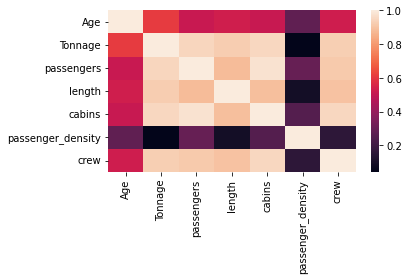

In [151]:
#Mapa de calor de la matriz de correlación
sns.heatmap(abs(corr_mat),xticklabels=corr_mat.columns.values,yticklabels=corr_mat.columns.values)
plt.tight_layout()
plt.show()

La siguiente celda nos muestra, en orden descendente, la importancia (correlación) de cada característica con respecto a la variable de salida.

In [152]:
#Orden de correlaciones con la salida
abs(corr_mat["crew"]).sort_values(ascending=False)

crew                 1.000000
cabins               0.950823
Tonnage              0.927569
passengers           0.915234
length               0.895857
Age                  0.530657
passenger_density    0.155509
Name: crew, dtype: float64

Ahora procedemos a eliminar la variable ($\texttt{crew}$) de nuestro conjunto de datos, pues de ahora en adelante la representaremos como nuestras etiquetas $y$. 

In [13]:
#Extraemos la variable a predecir (crew) de los datos 
datax = data.drop(['crew'], axis = 1) 
y = data['crew'].copy()

A continuación procedemos a graficar una a una nuestras características numéricas con respecto a la salida que queremos predecir. En las siguientes figuras podemos corroborar nuevamente el análisis hecho con la matriz de correlación de Pearson.

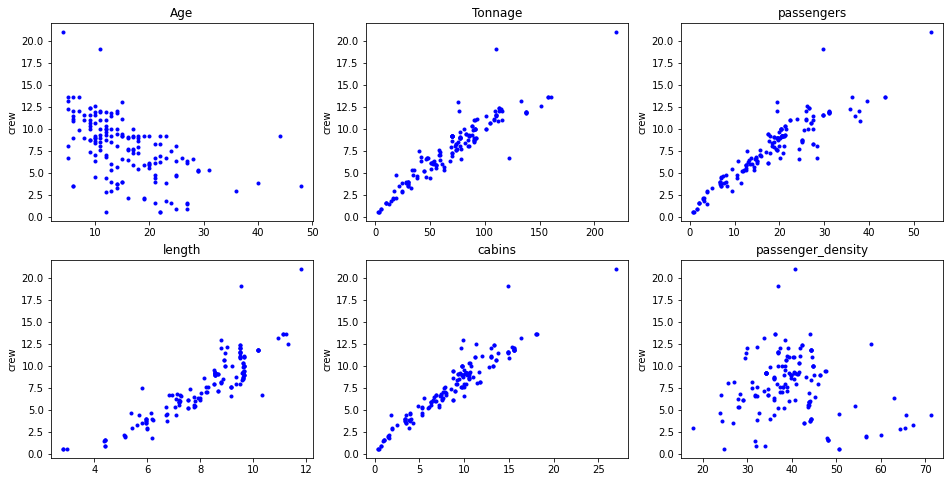

In [14]:
#Graficamos cada una de las características numéricas con respecto a la salida (crew)
fig, axs = plt.subplots(2, 3, figsize=(16,8))
k = 0
for ax in axs.flat:
    ax.plot(datax[datax.columns[k+2]], y, '.b')
    ax.set_title(datax.columns[k+2])
    ax.set(ylabel='crew')
    k=k+1

Para terminar esta sesión, es importante dejar claro que gracias a la alta correlación de la mayoría de nuestras variables, no es necesaria la implementación de un modelo de aprendizaje complejo, pues la información que hemos obtenido de nuestros datos hasta ahora nos indica que con un modelo lineal, relativamente simple, podríamos obtener resultados competitivos en la predicción del tamaño de la tripulación. Esto nos lleva a pensar que el trabajo de predecir la salida será ejecutado en mayor medida por las características que por el modelo.

# 3.Tratamiento de las variables categóricas

En la sesión anterior nos dedicamos a explorar las variables numéricas que componen nuestro set, en esta sesión daremos solución al problema de procesar las variables categóricas, pues los métodos de regresión son modelos que predicen siempre una salida real (continua), por lo tanto todas las variables de entrada deben ser numéricas. En primer lugar, eliminamos la primera columna de nuestros datos ($\texttt{Ship_name}$), debido a que corresponde al nombre de la nave y no debería tener ninguna relevancia para la predicción. Finalmente, esto nos deja con una sola variable categórica referente a la línea de cada crucero ($\texttt{Cruise_line}$)

In [15]:
#Eliminamos el nombre de las embarcaciones
datax = datax.drop(['Ship_name'], axis=1)

Para realizar la transformación de nuestra variable categórica, utilizaremos la clase $\texttt{OneHotEncoder}$ del paquete $\texttt{scikit-learn}$. Dicha clase nos permite crear una nueva característica binaria por cada categoría de nuestra variable de interés, permitiendonos así volverla numérica. Sin embargo se debe tener precaución, pues el número de características puede aumentar considerablemente.

In [16]:
#Aplicamos la transformación sobre nuestra variable categórica
encoder = OneHotEncoder(sparse = False)
data_cat = encoder.fit_transform(datax[['Cruise_line']])
data_cat

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

La clase $\texttt{OneHotEncoder}$ nos estrega por defecto un arreglo sparse (mayoría de elementos igual a cero) como vemos en la celda anterior. A continuación podemos observar cada una de los nombres de las categorías de nuestra variable y el tamaño del arreglo ya codificado.

In [153]:
#Extraemos las categorías
print(encoder.categories_)
print(data_cat.shape)

[array(['Azamara', 'Carnival', 'Celebrity', 'Costa', 'Crystal', 'Cunard',
       'Disney', 'Holland_American', 'MSC', 'Norwegian', 'Oceania',
       'Orient', 'P&O', 'Princess', 'Regent_Seven_Seas',
       'Royal_Caribbean', 'Seabourn', 'Silversea', 'Star', 'Windstar'],
      dtype=object)]
(158, 20)


En este punto, debemos proceder a  concatenar la variable codificadas con nuestro conjunto de datos numérico para formar nuestro set completo. Además debemos elminar la variable categórica que acabamos de transformar.

In [19]:
#Convertimos el arreglo obtenido anteriormente en un Dataframe 
data_cat = pd.DataFrame(data_cat, columns=np.unique(datax['Cruise_line']))
#Eliminamos la variable categórica
datax = datax.drop(['Cruise_line'], axis = 1)
#visualizamos la estructura de nuestro arreglo codificado
data_cat.head()

,Azamara,Carnival,Celebrity,Costa,Crystal,Cunard,Disney,Holland_American,MSC,Norwegian,Oceania,Orient,P&O,Princess,Regent_Seven_Seas,Royal_Caribbean,Seabourn,Silversea,Star,Windstar
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
#Concatenamos la variable transformada con el resto de nuestro set 
X = pd.concat([datax, data_cat], axis = 1)
#visualizamos la estructura de nuestro nuevo conjunto de entrada X
X.head()

,Age,Tonnage,passengers,length,cabins,passenger_density,Azamara,Carnival,Celebrity,Costa,...,Oceania,Orient,P&O,Princess,Regent_Seven_Seas,Royal_Caribbean,Seabourn,Silversea,Star,Windstar
0,6,30.277,6.94,5.94,3.55,42.64,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,30.277,6.94,5.94,3.55,42.64,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,26,47.262,14.86,7.22,7.43,31.80,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11,110.000,29.74,9.53,14.88,36.99,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17,101.353,26.42,8.92,13.21,38.36,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


En la celda anterior podemos ver que se han agragado veinte nuevas columnas a nuestros datos, pues la variable $\texttt{Cruise_line}$ tenía veinte diferentes categorías. En la siguiente celda podemos notar que las variables numéricas iniciales no han sufrido ningun cambio y nuestras nuevas variables son binarias y no presentan ningun dato espurio.

In [21]:
#Estadísticos básicos del conjunto de datos de entrada X
X.describe()

,Age,Tonnage,passengers,length,cabins,passenger_density,Azamara,Carnival,Celebrity,Costa,...,Oceania,Orient,P&O,Princess,Regent_Seven_Seas,Royal_Caribbean,Seabourn,Silversea,Star,Windstar
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,...,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,15.689873,71.284671,18.457405,8.130633,8.830000,39.900949,0.012658,0.139241,0.063291,0.069620,...,0.018987,0.006329,0.037975,0.107595,0.031646,0.145570,0.018987,0.025316,0.037975,0.018987
std,7.615691,37.229540,9.677095,1.793474,4.471417,8.639217,0.112150,0.347298,0.244260,0.255315,...,0.136914,0.079556,0.191743,0.310853,0.175611,0.353796,0.136914,0.157584,0.191743,0.136914
min,4.000000,2.329000,0.660000,2.790000,0.330000,17.700000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,46.013000,12.535000,7.100000,6.132500,34.570000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,14.000000,71.899000,19.500000,8.555000,9.570000,39.085000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,20.000000,90.772500,24.845000,9.510000,10.885000,44.185000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,48.000000,220.000000,54.000000,11.820000,27.000000,71.430000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
#Verificamos que no hayan datos nulos en nuestro set y que todas las variables sean numéricas
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                158 non-null    int64  
 1   Tonnage            158 non-null    float64
 2   passengers         158 non-null    float64
 3   length             158 non-null    float64
 4   cabins             158 non-null    float64
 5   passenger_density  158 non-null    float64
 6   Azamara            158 non-null    float64
 7   Carnival           158 non-null    float64
 8   Celebrity          158 non-null    float64
 9   Costa              158 non-null    float64
 10  Crystal            158 non-null    float64
 11  Cunard             158 non-null    float64
 12  Disney             158 non-null    float64
 13  Holland_American   158 non-null    float64
 14  MSC                158 non-null    float64
 15  Norwegian          158 non-null    float64
 16  Oceania            158 non

# 4. Preparamos los datos para entrenar el modelo

En esta parte debemos comenzar a preparar nuestros datos para alimentar el modelo de aprendizaje automático que vamos a implemetar. Inicialmente debemos generar las particiones correspondientes del set, con el fin de garantizar resultados confiables y generalizables. Además, calculamos la matriz de correlación de Pearson entre nuestros dos conjuntos (train, test). En esta podemos notar que evidentemente ambos conjuntos están alatamente correlacionados, pues en casi toda la matriz podemos notar que hay energía. 

<function matplotlib.pyplot.show(close=None, block=None)>

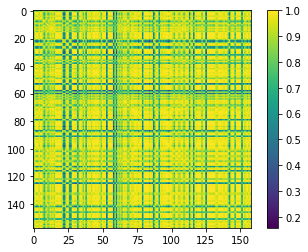

In [155]:
# Dividimos los datos en Train y Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=1)
#Calculamos el coeficiente de correlación de Pearson entre los dos conjutos (train y test)
corrXX = np.corrcoef(X_train, X_test)
plt.imshow(corrXX)
plt.colorbar()
plt.show

# 5. Selección de características

En esta sección implementamos una metodología que nos permita seleccionar de manera automática las características más relevantes a la hora de predecir nuestra etiqueta. Para esta tarea se usó el método $\texttt{SelectKBest}$ el cual tiene como parámetros la medida de desempeño (score) y el número de características a seleccionar ($k$). Como medida de desempeño se asignó al $f-$value y en primera instancia tomamos todas las características con el fin de comparar sus score a la hora de predecir la salida.

In [171]:
# función para seleccionar las etiquetas más relevantes
def select_features(X_train, y_train, X_test, k):
    # Seleccionamos todas las características
    fs = SelectKBest(score_func=f_regression, k=k)
    # Evaluamos en los datos de entrenamiento
    fs.fit(X_train, y_train)
    # Aplicamos la transformación
    X_train_fs = fs.transform(X_train)
    #Transformamos los datos de validación
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

0.Age: 27.482349
1.Tonnage: 542.102825
2.passengers: 475.613183
3.length: 331.142022
4.cabins: 871.389576
5.passenger_density: 6.036710
6.Azamara: 2.322881
7.Carnival: 10.844193
8.Celebrity: 0.013453
9.Costa: 0.107108
10.Crystal: 0.326660
11.Cunard: 0.275184
12.Disney: 0.209332
13.Holland_American: 2.192590
14.MSC: 0.056041
15.Norwegian: 0.256356
16.Oceania: 1.833713
17.Orient: 0.000000
18.P&O: 0.967620
19.Princess: 2.449270
20.Regent_Seven_Seas: 4.099437
21.Royal_Caribbean: 6.839956
22.Seabourn: 5.194829
23.Silversea: 5.522112
24.Star: 2.653313
25.Windstar: 5.677360


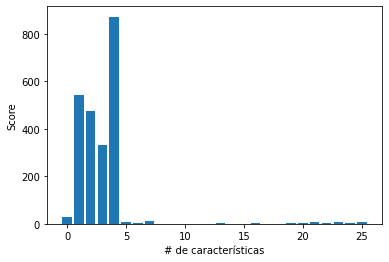

In [172]:
# Llamamos nuestra función de selección de característica
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, k ='all')#Usamos todas la columnas
# Imprimimos cada característica con su respectivo score
for i in range(len(fs.scores_)):
    print('%d.%s: %f' % (i, X.columns[i], fs.scores_[i]))
# Graficamos los score
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.xlabel('# de características')
plt.ylabel('Score')
plt.show()

In [173]:
X_train_fs.shape

(94, 26)

De los resultados anteriores podemos notar que las características que presentan una correlación de Pearson más alta, son efectivamente las que presentan el score más alto en nuestra metodología de selección. A continuación procederemos a entrenar un modelo de regresión lineal con el fin de predecir nuestra salida.

# 6. Modelo de regresión lineal para predecir la salida

Como se mencionó en la sección 2, se implementará un modelo lineal simple, ya que hemos comprobado que gracias a la correlación de las características con la salida este podría tener un desempeño competitivo. Primero usaremos la selección de características de acuerdo a los resultados de la sección anterior.

In [176]:
#Seleccionamos las 5 características más relevantes
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, k =5)#Fijamos el parámetro k en 5
#Definimos nuestro modelo de regresión
reg_lin = LinearRegression()
#Entrenamos el modelo evaluándolo en los datos de training
reg_lin.fit(X_train_fs, y_train)
#Evaluamos el modelo entrenado en los datos de validación
y_lin = reg_lin.predict(X_test_fs)

Finalmente, como medida de desempeño podemos establecer la correlación de Pearson entre las salidas reales y las predecidas por el modelo y el error cuadrático medio.

In [181]:
#Calculamos el coeficiente de correlación de Pearson
print(np.corrcoef(y_test, y_lin)[1][0])
#Calculamos el error cuadrático medio (MSE)
print(mean_squared_error(y_test, y_lin))

0.9709683120491359
0.49549925063634115


Los resultados anteriores nos muestran que el modelo de regresión lineal presenta un muy buen desempeño a la hora de predecir la salida, pues el coeficiente de correlación de Pearson entrega un valor de alrededor del $97\%$ y el MSE es bastante pequeño, teniendo en cuenta que usamos sólo 5 características. Sin embargo, cabe resaltar que la configuración del modelo se hizo de manera manual, pues el valor $k$ es un hyperparámetro libre que ajustamos manualmete. Por otro lado, la base de datos con la que contamos es muy pequeña, pueso solo tenemos acceso a 158 muestras, sin contar que nuestro modelo se entreno sólo con el $60\%$ de ese valor. Con base en lo anterior es menester plantear los siguientes inconvenientes:
* La selección del hyperparámetro $k$ se debe automatizar, pues no se tiene la certeza de cual es el valor óptimo.
* Teniendo en cuenta el poco tamaño de la base de datos y la poca variabilidad que estos presentan (ver sección 2), es posible que el modelo sufra de sobreajuste (overfitting). Esto afectaría la capacidad de generalización del modelo, viéndose afectado su desepeño a la hora de predecir nuevos valores para Cruceros distintos con los cuales no se haya realizado el entrenamiento.   

# 7. Regularización y sintonización de los hyperparámetros del modelo

Con el fin de contrarrestar el posible sobreajuste del modelo, es necesario llevar a cabo un procedimiento de regularización, el cual consiste en agregar al modelo un término que depende de los parámetros de este. Los casos más comunes de regularización son la regresión Rígida y la Regresion de Lasso, las cuales están basadas en la norma $l_2$ y $l_1$ respectivamente. Esto con el fin de suavizar los resultados y minimizar la complejidad del modelo, lo cual implica una mejor capacidad de generalización.

En este vamos a implementar un método de regulación de Lasso, el cual depende de un parámetro de regularización ($\alpha$), el cual debe ser sintonizado de manera adecuada. Por lo tanto podemos identificar como hyperparámetros del modelo a $\alpha$ y $k$. A continuación se implementa una metodología basada en un $\texttt{pipeline}$ y un Gridsearch con el fin de seleccionar el modelo que mejor prediga la salida, buscando automáticamente los hyperparámetros.

In [182]:
#Preparamos el pipeline
steps=[('selfeat',  SelectKBest(score_func=f_regression)),#Método de selección
     ('linear', Lasso())] #Modelo de regresión con regularización
parameters = [
            {'selfeat__k': list(range(1,X.shape[1]+1)),#Grilla de los posibles valores de k (numero de características)
             'linear__alpha': [0.001,0.01,0.1,1,100,1000]},#Grilla para la búsqueda de alpha. Se trata de abarcar el mayor
                                                     #espacio posible
]

label_model = ['Regression']

In [183]:
#Aquí evaluamos todas la combinaciones posibles de los parámetros anteriores
#usamos 10 folds para validación cruzada
grid_search = GridSearchCV(Pipeline(steps),parameters,cv=10,verbose=100,scoring="neg_mean_squared_error",return_train_score=True)
#generar mejor modelo
grid_search.fit(X_train,y_train)
#estimar salida conjunto de test
y_pred = grid_search.best_estimator_.predict(X_test)

Fitting 10 folds for each of 156 candidates, totalling 1560 fits
[CV 1/10; 1/156] START linear__alpha=0.001, selfeat__k=1........................
[CV 1/10; 1/156] END linear__alpha=0.001, selfeat__k=1;, score=(train=-1.555, test=-0.400) total time=   0.0s
[CV 2/10; 1/156] START linear__alpha=0.001, selfeat__k=1........................
[CV 2/10; 1/156] END linear__alpha=0.001, selfeat__k=1;, score=(train=-1.569, test=-0.279) total time=   0.0s
[CV 3/10; 1/156] START linear__alpha=0.001, selfeat__k=1........................
[CV 3/10; 1/156] END linear__alpha=0.001, selfeat__k=1;, score=(train=-1.301, test=-2.555) total time=   0.0s
[CV 4/10; 1/156] START linear__alpha=0.001, selfeat__k=1........................
[CV 4/10; 1/156] END linear__alpha=0.001, selfeat__k=1;, score=(train=-1.533, test=-0.627) total time=   0.0s
[CV 5/10; 1/156] START linear__alpha=0.001, selfeat__k=1........................
[CV 5/10; 1/156] END linear__alpha=0.001, selfeat__k=1;, score=(train=-1.487, test=-0.955)

[CV 1/10; 7/156] END linear__alpha=0.001, selfeat__k=7;, score=(train=-1.163, test=-0.276) total time=   0.0s
[CV 2/10; 7/156] START linear__alpha=0.001, selfeat__k=7........................
[CV 2/10; 7/156] END linear__alpha=0.001, selfeat__k=7;, score=(train=-1.282, test=-0.295) total time=   0.0s
[CV 3/10; 7/156] START linear__alpha=0.001, selfeat__k=7........................
[CV 3/10; 7/156] END linear__alpha=0.001, selfeat__k=7;, score=(train=-1.020, test=-2.612) total time=   0.0s
[CV 4/10; 7/156] START linear__alpha=0.001, selfeat__k=7........................
[CV 4/10; 7/156] END linear__alpha=0.001, selfeat__k=7;, score=(train=-1.183, test=-0.105) total time=   0.0s
[CV 5/10; 7/156] START linear__alpha=0.001, selfeat__k=7........................
[CV 5/10; 7/156] END linear__alpha=0.001, selfeat__k=7;, score=(train=-1.086, test=-1.006) total time=   0.0s
[CV 6/10; 7/156] START linear__alpha=0.001, selfeat__k=7........................
[CV 6/10; 7/156] END linear__alpha=0.001, sel

[CV 9/10; 12/156] END linear__alpha=0.001, selfeat__k=12;, score=(train=-1.138, test=-0.443) total time=   0.0s
[CV 10/10; 12/156] START linear__alpha=0.001, selfeat__k=12.....................
[CV 10/10; 12/156] END linear__alpha=0.001, selfeat__k=12;, score=(train=-1.074, test=-0.251) total time=   0.0s
[CV 1/10; 13/156] START linear__alpha=0.001, selfeat__k=13......................
[CV 1/10; 13/156] END linear__alpha=0.001, selfeat__k=13;, score=(train=-1.074, test=-0.286) total time=   0.0s
[CV 2/10; 13/156] START linear__alpha=0.001, selfeat__k=13......................
[CV 2/10; 13/156] END linear__alpha=0.001, selfeat__k=13;, score=(train=-1.068, test=-0.366) total time=   0.0s
[CV 3/10; 13/156] START linear__alpha=0.001, selfeat__k=13......................
[CV 3/10; 13/156] END linear__alpha=0.001, selfeat__k=13;, score=(train=-0.884, test=-2.294) total time=   0.0s
[CV 4/10; 13/156] START linear__alpha=0.001, selfeat__k=13......................
[CV 4/10; 13/156] END linear__alph

[CV 5/10; 18/156] END linear__alpha=0.001, selfeat__k=18;, score=(train=-0.984, test=-0.761) total time=   0.0s
[CV 6/10; 18/156] START linear__alpha=0.001, selfeat__k=18......................
[CV 6/10; 18/156] END linear__alpha=0.001, selfeat__k=18;, score=(train=-0.495, test=-5.654) total time=   0.0s
[CV 7/10; 18/156] START linear__alpha=0.001, selfeat__k=18......................
[CV 7/10; 18/156] END linear__alpha=0.001, selfeat__k=18;, score=(train=-0.987, test=-0.907) total time=   0.0s
[CV 8/10; 18/156] START linear__alpha=0.001, selfeat__k=18......................
[CV 8/10; 18/156] END linear__alpha=0.001, selfeat__k=18;, score=(train=-0.940, test=-1.357) total time=   0.0s
[CV 9/10; 18/156] START linear__alpha=0.001, selfeat__k=18......................
[CV 9/10; 18/156] END linear__alpha=0.001, selfeat__k=18;, score=(train=-1.013, test=-0.431) total time=   0.0s
[CV 10/10; 18/156] START linear__alpha=0.001, selfeat__k=18.....................
[CV 10/10; 18/156] END linear__alph

[CV 10/10; 23/156] END linear__alpha=0.001, selfeat__k=23;, score=(train=-0.987, test=-0.243) total time=   0.0s
[CV 1/10; 24/156] START linear__alpha=0.001, selfeat__k=24......................
[CV 1/10; 24/156] END linear__alpha=0.001, selfeat__k=24;, score=(train=-0.988, test=-0.219) total time=   0.0s
[CV 2/10; 24/156] START linear__alpha=0.001, selfeat__k=24......................
[CV 2/10; 24/156] END linear__alpha=0.001, selfeat__k=24;, score=(train=-0.984, test=-0.311) total time=   0.0s
[CV 3/10; 24/156] START linear__alpha=0.001, selfeat__k=24......................
[CV 3/10; 24/156] END linear__alpha=0.001, selfeat__k=24;, score=(train=-0.751, test=-2.597) total time=   0.0s
[CV 4/10; 24/156] START linear__alpha=0.001, selfeat__k=24......................
[CV 4/10; 24/156] END linear__alpha=0.001, selfeat__k=24;, score=(train=-1.003, test=-0.089) total time=   0.0s
[CV 5/10; 24/156] START linear__alpha=0.001, selfeat__k=24......................
[CV 5/10; 24/156] END linear__alph

[CV 1/10; 30/156] END linear__alpha=0.01, selfeat__k=4;, score=(train=-1.337, test=-0.433) total time=   0.0s
[CV 2/10; 30/156] START linear__alpha=0.01, selfeat__k=4........................
[CV 2/10; 30/156] END linear__alpha=0.01, selfeat__k=4;, score=(train=-1.347, test=-0.339) total time=   0.0s
[CV 3/10; 30/156] START linear__alpha=0.01, selfeat__k=4........................
[CV 3/10; 30/156] END linear__alpha=0.01, selfeat__k=4;, score=(train=-1.128, test=-2.238) total time=   0.0s
[CV 4/10; 30/156] START linear__alpha=0.01, selfeat__k=4........................
[CV 4/10; 30/156] END linear__alpha=0.01, selfeat__k=4;, score=(train=-1.354, test=-0.287) total time=   0.0s
[CV 5/10; 30/156] START linear__alpha=0.01, selfeat__k=4........................
[CV 5/10; 30/156] END linear__alpha=0.01, selfeat__k=4;, score=(train=-1.300, test=-0.704) total time=   0.0s
[CV 6/10; 30/156] START linear__alpha=0.01, selfeat__k=4........................
[CV 6/10; 30/156] END linear__alpha=0.01, sel

[CV 1/10; 36/156] END linear__alpha=0.01, selfeat__k=10;, score=(train=-1.163, test=-0.275) total time=   0.0s
[CV 2/10; 36/156] START linear__alpha=0.01, selfeat__k=10.......................
[CV 2/10; 36/156] END linear__alpha=0.01, selfeat__k=10;, score=(train=-1.165, test=-0.248) total time=   0.0s
[CV 3/10; 36/156] START linear__alpha=0.01, selfeat__k=10.......................
[CV 3/10; 36/156] END linear__alpha=0.01, selfeat__k=10;, score=(train=-0.921, test=-2.425) total time=   0.0s
[CV 4/10; 36/156] START linear__alpha=0.01, selfeat__k=10.......................
[CV 4/10; 36/156] END linear__alpha=0.01, selfeat__k=10;, score=(train=-1.183, test=-0.103) total time=   0.0s
[CV 5/10; 36/156] START linear__alpha=0.01, selfeat__k=10.......................
[CV 5/10; 36/156] END linear__alpha=0.01, selfeat__k=10;, score=(train=-1.085, test=-0.986) total time=   0.0s
[CV 6/10; 36/156] START linear__alpha=0.01, selfeat__k=10.......................
[CV 6/10; 36/156] END linear__alpha=0.01

[CV 10/10; 41/156] END linear__alpha=0.01, selfeat__k=15;, score=(train=-1.042, test=-0.296) total time=   0.0s
[CV 1/10; 42/156] START linear__alpha=0.01, selfeat__k=16.......................
[CV 1/10; 42/156] END linear__alpha=0.01, selfeat__k=16;, score=(train=-1.059, test=-0.217) total time=   0.0s
[CV 2/10; 42/156] START linear__alpha=0.01, selfeat__k=16.......................
[CV 2/10; 42/156] END linear__alpha=0.01, selfeat__k=16;, score=(train=-1.059, test=-0.203) total time=   0.0s
[CV 3/10; 42/156] START linear__alpha=0.01, selfeat__k=16.......................
[CV 3/10; 42/156] END linear__alpha=0.01, selfeat__k=16;, score=(train=-0.834, test=-2.217) total time=   0.0s
[CV 4/10; 42/156] START linear__alpha=0.01, selfeat__k=16.......................
[CV 4/10; 42/156] END linear__alpha=0.01, selfeat__k=16;, score=(train=-1.069, test=-0.120) total time=   0.0s
[CV 5/10; 42/156] START linear__alpha=0.01, selfeat__k=16.......................
[CV 5/10; 42/156] END linear__alpha=0.0

[CV 8/10; 47/156] END linear__alpha=0.01, selfeat__k=21;, score=(train=-0.955, test=-1.505) total time=   0.0s
[CV 9/10; 47/156] START linear__alpha=0.01, selfeat__k=21.......................
[CV 9/10; 47/156] END linear__alpha=0.01, selfeat__k=21;, score=(train=-1.022, test=-0.351) total time=   0.0s
[CV 10/10; 47/156] START linear__alpha=0.01, selfeat__k=21......................
[CV 10/10; 47/156] END linear__alpha=0.01, selfeat__k=21;, score=(train=-1.028, test=-0.245) total time=   0.0s
[CV 1/10; 48/156] START linear__alpha=0.01, selfeat__k=22.......................
[CV 1/10; 48/156] END linear__alpha=0.01, selfeat__k=22;, score=(train=-1.059, test=-0.217) total time=   0.0s
[CV 2/10; 48/156] START linear__alpha=0.01, selfeat__k=22.......................
[CV 2/10; 48/156] END linear__alpha=0.01, selfeat__k=22;, score=(train=-1.038, test=-0.217) total time=   0.0s
[CV 3/10; 48/156] START linear__alpha=0.01, selfeat__k=22.......................
[CV 3/10; 48/156] END linear__alpha=0.0

[CV 5/10; 53/156] END linear__alpha=0.1, selfeat__k=1;, score=(train=-1.487, test=-0.945) total time=   0.0s
[CV 6/10; 53/156] START linear__alpha=0.1, selfeat__k=1.........................
[CV 6/10; 53/156] END linear__alpha=0.1, selfeat__k=1;, score=(train=-0.969, test=-5.921) total time=   0.0s
[CV 7/10; 53/156] START linear__alpha=0.1, selfeat__k=1.........................
[CV 7/10; 53/156] END linear__alpha=0.1, selfeat__k=1;, score=(train=-1.546, test=-0.372) total time=   0.0s
[CV 8/10; 53/156] START linear__alpha=0.1, selfeat__k=1.........................
[CV 8/10; 53/156] END linear__alpha=0.1, selfeat__k=1;, score=(train=-1.380, test=-1.925) total time=   0.0s
[CV 9/10; 53/156] START linear__alpha=0.1, selfeat__k=1.........................
[CV 9/10; 53/156] END linear__alpha=0.1, selfeat__k=1;, score=(train=-1.467, test=-1.137) total time=   0.0s
[CV 10/10; 53/156] START linear__alpha=0.1, selfeat__k=1........................
[CV 10/10; 53/156] END linear__alpha=0.1, selfeat_

[CV 7/10; 59/156] END linear__alpha=0.1, selfeat__k=7;, score=(train=-1.297, test=-0.350) total time=   0.0s
[CV 8/10; 59/156] START linear__alpha=0.1, selfeat__k=7.........................
[CV 8/10; 59/156] END linear__alpha=0.1, selfeat__k=7;, score=(train=-1.153, test=-1.664) total time=   0.0s
[CV 9/10; 59/156] START linear__alpha=0.1, selfeat__k=7.........................
[CV 9/10; 59/156] END linear__alpha=0.1, selfeat__k=7;, score=(train=-1.350, test=-0.677) total time=   0.0s
[CV 10/10; 59/156] START linear__alpha=0.1, selfeat__k=7........................
[CV 10/10; 59/156] END linear__alpha=0.1, selfeat__k=7;, score=(train=-1.328, test=-0.897) total time=   0.0s
[CV 1/10; 60/156] START linear__alpha=0.1, selfeat__k=8.........................
[CV 1/10; 60/156] END linear__alpha=0.1, selfeat__k=8;, score=(train=-1.296, test=-0.374) total time=   0.0s
[CV 2/10; 60/156] START linear__alpha=0.1, selfeat__k=8.........................
[CV 2/10; 60/156] END linear__alpha=0.1, selfeat_

[CV 6/10; 65/156] END linear__alpha=0.1, selfeat__k=13;, score=(train=-0.758, test=-6.131) total time=   0.0s
[CV 7/10; 65/156] START linear__alpha=0.1, selfeat__k=13........................
[CV 7/10; 65/156] END linear__alpha=0.1, selfeat__k=13;, score=(train=-1.297, test=-0.350) total time=   0.0s
[CV 8/10; 65/156] START linear__alpha=0.1, selfeat__k=13........................
[CV 8/10; 65/156] END linear__alpha=0.1, selfeat__k=13;, score=(train=-1.152, test=-1.663) total time=   0.0s
[CV 9/10; 65/156] START linear__alpha=0.1, selfeat__k=13........................
[CV 9/10; 65/156] END linear__alpha=0.1, selfeat__k=13;, score=(train=-1.294, test=-0.594) total time=   0.0s
[CV 10/10; 65/156] START linear__alpha=0.1, selfeat__k=13.......................
[CV 10/10; 65/156] END linear__alpha=0.1, selfeat__k=13;, score=(train=-1.316, test=-0.847) total time=   0.0s
[CV 1/10; 66/156] START linear__alpha=0.1, selfeat__k=14........................
[CV 1/10; 66/156] END linear__alpha=0.1, sel

[CV 5/10; 71/156] END linear__alpha=0.1, selfeat__k=19;, score=(train=-1.213, test=-0.786) total time=   0.0s
[CV 6/10; 71/156] START linear__alpha=0.1, selfeat__k=19........................
[CV 6/10; 71/156] END linear__alpha=0.1, selfeat__k=19;, score=(train=-0.758, test=-6.131) total time=   0.0s
[CV 7/10; 71/156] START linear__alpha=0.1, selfeat__k=19........................
[CV 7/10; 71/156] END linear__alpha=0.1, selfeat__k=19;, score=(train=-1.297, test=-0.350) total time=   0.0s
[CV 8/10; 71/156] START linear__alpha=0.1, selfeat__k=19........................
[CV 8/10; 71/156] END linear__alpha=0.1, selfeat__k=19;, score=(train=-1.152, test=-1.663) total time=   0.0s
[CV 9/10; 71/156] START linear__alpha=0.1, selfeat__k=19........................
[CV 9/10; 71/156] END linear__alpha=0.1, selfeat__k=19;, score=(train=-1.294, test=-0.594) total time=   0.0s
[CV 10/10; 71/156] START linear__alpha=0.1, selfeat__k=19.......................
[CV 10/10; 71/156] END linear__alpha=0.1, sel

[CV 3/10; 77/156] END linear__alpha=0.1, selfeat__k=25;, score=(train=-1.080, test=-2.376) total time=   0.0s
[CV 4/10; 77/156] START linear__alpha=0.1, selfeat__k=25........................
[CV 4/10; 77/156] END linear__alpha=0.1, selfeat__k=25;, score=(train=-1.326, test=-0.246) total time=   0.0s
[CV 5/10; 77/156] START linear__alpha=0.1, selfeat__k=25........................
[CV 5/10; 77/156] END linear__alpha=0.1, selfeat__k=25;, score=(train=-1.213, test=-0.786) total time=   0.0s
[CV 6/10; 77/156] START linear__alpha=0.1, selfeat__k=25........................
[CV 6/10; 77/156] END linear__alpha=0.1, selfeat__k=25;, score=(train=-0.758, test=-6.131) total time=   0.0s
[CV 7/10; 77/156] START linear__alpha=0.1, selfeat__k=25........................
[CV 7/10; 77/156] END linear__alpha=0.1, selfeat__k=25;, score=(train=-1.297, test=-0.350) total time=   0.0s
[CV 8/10; 77/156] START linear__alpha=0.1, selfeat__k=25........................
[CV 8/10; 77/156] END linear__alpha=0.1, self

[CV 3/10; 83/156] END linear__alpha=1, selfeat__k=5;, score=(train=-1.652, test=-2.921) total time=   0.0s
[CV 4/10; 83/156] START linear__alpha=1, selfeat__k=5...........................
[CV 4/10; 83/156] END linear__alpha=1, selfeat__k=5;, score=(train=-1.898, test=-0.423) total time=   0.0s
[CV 5/10; 83/156] START linear__alpha=1, selfeat__k=5...........................
[CV 5/10; 83/156] END linear__alpha=1, selfeat__k=5;, score=(train=-1.864, test=-0.557) total time=   0.0s
[CV 6/10; 83/156] START linear__alpha=1, selfeat__k=5...........................
[CV 6/10; 83/156] END linear__alpha=1, selfeat__k=5;, score=(train=-1.299, test=-7.417) total time=   0.0s
[CV 7/10; 83/156] START linear__alpha=1, selfeat__k=5...........................
[CV 7/10; 83/156] END linear__alpha=1, selfeat__k=5;, score=(train=-1.850, test=-4.420) total time=   0.0s
[CV 8/10; 83/156] START linear__alpha=1, selfeat__k=5...........................
[CV 8/10; 83/156] END linear__alpha=1, selfeat__k=5;, score=

[CV 10/10; 88/156] END linear__alpha=1, selfeat__k=10;, score=(train=-1.923, test=-1.613) total time=   0.0s
[CV 1/10; 89/156] START linear__alpha=1, selfeat__k=11..........................
[CV 1/10; 89/156] END linear__alpha=1, selfeat__k=11;, score=(train=-1.975, test=-0.708) total time=   0.0s
[CV 2/10; 89/156] START linear__alpha=1, selfeat__k=11..........................
[CV 2/10; 89/156] END linear__alpha=1, selfeat__k=11;, score=(train=-1.995, test=-0.384) total time=   0.0s
[CV 3/10; 89/156] START linear__alpha=1, selfeat__k=11..........................
[CV 3/10; 89/156] END linear__alpha=1, selfeat__k=11;, score=(train=-1.739, test=-2.933) total time=   0.0s
[CV 4/10; 89/156] START linear__alpha=1, selfeat__k=11..........................
[CV 4/10; 89/156] END linear__alpha=1, selfeat__k=11;, score=(train=-1.973, test=-0.377) total time=   0.0s
[CV 5/10; 89/156] START linear__alpha=1, selfeat__k=11..........................
[CV 5/10; 89/156] END linear__alpha=1, selfeat__k=11;,

[CV 2/10; 95/156] END linear__alpha=1, selfeat__k=17;, score=(train=-1.995, test=-0.384) total time=   0.0s
[CV 3/10; 95/156] START linear__alpha=1, selfeat__k=17..........................
[CV 3/10; 95/156] END linear__alpha=1, selfeat__k=17;, score=(train=-1.739, test=-2.933) total time=   0.0s
[CV 4/10; 95/156] START linear__alpha=1, selfeat__k=17..........................
[CV 4/10; 95/156] END linear__alpha=1, selfeat__k=17;, score=(train=-1.973, test=-0.377) total time=   0.0s
[CV 5/10; 95/156] START linear__alpha=1, selfeat__k=17..........................
[CV 5/10; 95/156] END linear__alpha=1, selfeat__k=17;, score=(train=-1.944, test=-0.553) total time=   0.0s
[CV 6/10; 95/156] START linear__alpha=1, selfeat__k=17..........................
[CV 6/10; 95/156] END linear__alpha=1, selfeat__k=17;, score=(train=-1.390, test=-7.525) total time=   0.0s
[CV 7/10; 95/156] START linear__alpha=1, selfeat__k=17..........................
[CV 7/10; 95/156] END linear__alpha=1, selfeat__k=17;, 

[CV 10/10; 100/156] END linear__alpha=1, selfeat__k=22;, score=(train=-1.923, test=-1.613) total time=   0.0s
[CV 1/10; 101/156] START linear__alpha=1, selfeat__k=23.........................
[CV 1/10; 101/156] END linear__alpha=1, selfeat__k=23;, score=(train=-1.975, test=-0.708) total time=   0.0s
[CV 2/10; 101/156] START linear__alpha=1, selfeat__k=23.........................
[CV 2/10; 101/156] END linear__alpha=1, selfeat__k=23;, score=(train=-1.995, test=-0.384) total time=   0.0s
[CV 3/10; 101/156] START linear__alpha=1, selfeat__k=23.........................
[CV 3/10; 101/156] END linear__alpha=1, selfeat__k=23;, score=(train=-1.739, test=-2.933) total time=   0.0s
[CV 4/10; 101/156] START linear__alpha=1, selfeat__k=23.........................
[CV 4/10; 101/156] END linear__alpha=1, selfeat__k=23;, score=(train=-1.973, test=-0.377) total time=   0.0s
[CV 5/10; 101/156] START linear__alpha=1, selfeat__k=23.........................
[CV 5/10; 101/156] END linear__alpha=1, selfeat__

[CV 8/10; 106/156] END linear__alpha=100, selfeat__k=2;, score=(train=-8.065, test=-4.839) total time=   0.0s
[CV 9/10; 106/156] START linear__alpha=100, selfeat__k=2........................
[CV 9/10; 106/156] END linear__alpha=100, selfeat__k=2;, score=(train=-9.527, test=-21.445) total time=   0.0s
[CV 10/10; 106/156] START linear__alpha=100, selfeat__k=2.......................
[CV 10/10; 106/156] END linear__alpha=100, selfeat__k=2;, score=(train=-8.813, test=-6.613) total time=   0.0s
[CV 1/10; 107/156] START linear__alpha=100, selfeat__k=3........................
[CV 1/10; 107/156] END linear__alpha=100, selfeat__k=3;, score=(train=-8.488, test=-6.323) total time=   0.0s
[CV 2/10; 107/156] START linear__alpha=100, selfeat__k=3........................
[CV 2/10; 107/156] END linear__alpha=100, selfeat__k=3;, score=(train=-8.267, test=-2.216) total time=   0.0s
[CV 3/10; 107/156] START linear__alpha=100, selfeat__k=3........................
[CV 3/10; 107/156] END linear__alpha=100, s

[CV 2/10; 111/156] END linear__alpha=100, selfeat__k=7;, score=(train=-8.267, test=-2.216) total time=   0.0s
[CV 3/10; 111/156] START linear__alpha=100, selfeat__k=7........................
[CV 3/10; 111/156] END linear__alpha=100, selfeat__k=7;, score=(train=-8.477, test=-13.204) total time=   0.0s
[CV 4/10; 111/156] START linear__alpha=100, selfeat__k=7........................
[CV 4/10; 111/156] END linear__alpha=100, selfeat__k=7;, score=(train=-8.775, test=-8.033) total time=   0.0s
[CV 5/10; 111/156] START linear__alpha=100, selfeat__k=7........................
[CV 5/10; 111/156] END linear__alpha=100, selfeat__k=7;, score=(train=-8.192, test=-2.351) total time=   0.0s
[CV 6/10; 111/156] START linear__alpha=100, selfeat__k=7........................
[CV 6/10; 111/156] END linear__alpha=100, selfeat__k=7;, score=(train=-7.835, test=-17.894) total time=   0.0s
[CV 7/10; 111/156] START linear__alpha=100, selfeat__k=7........................
[CV 7/10; 111/156] END linear__alpha=100, s

[CV 5/10; 117/156] END linear__alpha=100, selfeat__k=13;, score=(train=-8.192, test=-2.351) total time=   0.0s
[CV 6/10; 117/156] START linear__alpha=100, selfeat__k=13.......................
[CV 6/10; 117/156] END linear__alpha=100, selfeat__k=13;, score=(train=-7.835, test=-17.894) total time=   0.0s
[CV 7/10; 117/156] START linear__alpha=100, selfeat__k=13.......................
[CV 7/10; 117/156] END linear__alpha=100, selfeat__k=13;, score=(train=-8.180, test=-9.627) total time=   0.0s
[CV 8/10; 117/156] START linear__alpha=100, selfeat__k=13.......................
[CV 8/10; 117/156] END linear__alpha=100, selfeat__k=13;, score=(train=-8.065, test=-4.839) total time=   0.0s
[CV 9/10; 117/156] START linear__alpha=100, selfeat__k=13.......................
[CV 9/10; 117/156] END linear__alpha=100, selfeat__k=13;, score=(train=-9.527, test=-21.445) total time=   0.0s
[CV 10/10; 117/156] START linear__alpha=100, selfeat__k=13......................
[CV 10/10; 117/156] END linear__alpha=

[CV 7/10; 123/156] END linear__alpha=100, selfeat__k=19;, score=(train=-8.180, test=-9.627) total time=   0.0s
[CV 8/10; 123/156] START linear__alpha=100, selfeat__k=19.......................
[CV 8/10; 123/156] END linear__alpha=100, selfeat__k=19;, score=(train=-8.065, test=-4.839) total time=   0.0s
[CV 9/10; 123/156] START linear__alpha=100, selfeat__k=19.......................
[CV 9/10; 123/156] END linear__alpha=100, selfeat__k=19;, score=(train=-9.527, test=-21.445) total time=   0.0s
[CV 10/10; 123/156] START linear__alpha=100, selfeat__k=19......................
[CV 10/10; 123/156] END linear__alpha=100, selfeat__k=19;, score=(train=-8.813, test=-6.613) total time=   0.0s
[CV 1/10; 124/156] START linear__alpha=100, selfeat__k=20.......................
[CV 1/10; 124/156] END linear__alpha=100, selfeat__k=20;, score=(train=-8.488, test=-6.323) total time=   0.0s
[CV 2/10; 124/156] START linear__alpha=100, selfeat__k=20.......................
[CV 2/10; 124/156] END linear__alpha=1

[CV 10/10; 127/156] END linear__alpha=100, selfeat__k=23;, score=(train=-8.813, test=-6.613) total time=   0.0s
[CV 1/10; 128/156] START linear__alpha=100, selfeat__k=24.......................
[CV 1/10; 128/156] END linear__alpha=100, selfeat__k=24;, score=(train=-8.488, test=-6.323) total time=   0.0s
[CV 2/10; 128/156] START linear__alpha=100, selfeat__k=24.......................
[CV 2/10; 128/156] END linear__alpha=100, selfeat__k=24;, score=(train=-8.267, test=-2.216) total time=   0.0s
[CV 3/10; 128/156] START linear__alpha=100, selfeat__k=24.......................
[CV 3/10; 128/156] END linear__alpha=100, selfeat__k=24;, score=(train=-8.477, test=-13.204) total time=   0.0s
[CV 4/10; 128/156] START linear__alpha=100, selfeat__k=24.......................
[CV 4/10; 128/156] END linear__alpha=100, selfeat__k=24;, score=(train=-8.775, test=-8.033) total time=   0.0s
[CV 5/10; 128/156] START linear__alpha=100, selfeat__k=24.......................
[CV 5/10; 128/156] END linear__alpha=1

[CV 3/10; 134/156] END linear__alpha=1000, selfeat__k=4;, score=(train=-14.262, test=-21.177) total time=   0.0s
[CV 4/10; 134/156] START linear__alpha=1000, selfeat__k=4.......................
[CV 4/10; 134/156] END linear__alpha=1000, selfeat__k=4;, score=(train=-14.943, test=-15.452) total time=   0.0s
[CV 5/10; 134/156] START linear__alpha=1000, selfeat__k=4.......................
[CV 5/10; 134/156] END linear__alpha=1000, selfeat__k=4;, score=(train=-16.072, test=-4.802) total time=   0.0s
[CV 6/10; 134/156] START linear__alpha=1000, selfeat__k=4.......................
[CV 6/10; 134/156] END linear__alpha=1000, selfeat__k=4;, score=(train=-13.904, test=-25.442) total time=   0.0s
[CV 7/10; 134/156] START linear__alpha=1000, selfeat__k=4.......................
[CV 7/10; 134/156] END linear__alpha=1000, selfeat__k=4;, score=(train=-14.961, test=-15.955) total time=   0.0s
[CV 8/10; 134/156] START linear__alpha=1000, selfeat__k=4.......................
[CV 8/10; 134/156] END linear__

[CV 6/10; 138/156] END linear__alpha=1000, selfeat__k=8;, score=(train=-13.904, test=-25.442) total time=   0.0s
[CV 7/10; 138/156] START linear__alpha=1000, selfeat__k=8.......................
[CV 7/10; 138/156] END linear__alpha=1000, selfeat__k=8;, score=(train=-14.961, test=-15.955) total time=   0.0s
[CV 8/10; 138/156] START linear__alpha=1000, selfeat__k=8.......................
[CV 8/10; 138/156] END linear__alpha=1000, selfeat__k=8;, score=(train=-15.741, test=-7.922) total time=   0.0s
[CV 9/10; 138/156] START linear__alpha=1000, selfeat__k=8.......................
[CV 9/10; 138/156] END linear__alpha=1000, selfeat__k=8;, score=(train=-13.296, test=-31.706) total time=   0.0s
[CV 10/10; 138/156] START linear__alpha=1000, selfeat__k=8......................
[CV 10/10; 138/156] END linear__alpha=1000, selfeat__k=8;, score=(train=-15.089, test=-14.108) total time=   0.0s
[CV 1/10; 139/156] START linear__alpha=1000, selfeat__k=9.......................
[CV 1/10; 139/156] END linear_

[CV 9/10; 142/156] END linear__alpha=1000, selfeat__k=12;, score=(train=-13.296, test=-31.706) total time=   0.0s
[CV 10/10; 142/156] START linear__alpha=1000, selfeat__k=12.....................
[CV 10/10; 142/156] END linear__alpha=1000, selfeat__k=12;, score=(train=-15.089, test=-14.108) total time=   0.0s
[CV 1/10; 143/156] START linear__alpha=1000, selfeat__k=13......................
[CV 1/10; 143/156] END linear__alpha=1000, selfeat__k=13;, score=(train=-15.317, test=-12.256) total time=   0.0s
[CV 2/10; 143/156] START linear__alpha=1000, selfeat__k=13......................
[CV 2/10; 143/156] END linear__alpha=1000, selfeat__k=13;, score=(train=-16.153, test=-5.334) total time=   0.0s
[CV 3/10; 143/156] START linear__alpha=1000, selfeat__k=13......................
[CV 3/10; 143/156] END linear__alpha=1000, selfeat__k=13;, score=(train=-14.262, test=-21.177) total time=   0.0s
[CV 4/10; 143/156] START linear__alpha=1000, selfeat__k=13......................
[CV 4/10; 143/156] END li

[CV 3/10; 147/156] END linear__alpha=1000, selfeat__k=17;, score=(train=-14.262, test=-21.177) total time=   0.0s
[CV 4/10; 147/156] START linear__alpha=1000, selfeat__k=17......................
[CV 4/10; 147/156] END linear__alpha=1000, selfeat__k=17;, score=(train=-14.943, test=-15.452) total time=   0.0s
[CV 5/10; 147/156] START linear__alpha=1000, selfeat__k=17......................
[CV 5/10; 147/156] END linear__alpha=1000, selfeat__k=17;, score=(train=-16.072, test=-4.802) total time=   0.0s
[CV 6/10; 147/156] START linear__alpha=1000, selfeat__k=17......................
[CV 6/10; 147/156] END linear__alpha=1000, selfeat__k=17;, score=(train=-13.904, test=-25.442) total time=   0.0s
[CV 7/10; 147/156] START linear__alpha=1000, selfeat__k=17......................
[CV 7/10; 147/156] END linear__alpha=1000, selfeat__k=17;, score=(train=-14.961, test=-15.955) total time=   0.0s
[CV 8/10; 147/156] START linear__alpha=1000, selfeat__k=17......................
[CV 8/10; 147/156] END lin

[CV 6/10; 151/156] END linear__alpha=1000, selfeat__k=21;, score=(train=-13.904, test=-25.442) total time=   0.0s
[CV 7/10; 151/156] START linear__alpha=1000, selfeat__k=21......................
[CV 7/10; 151/156] END linear__alpha=1000, selfeat__k=21;, score=(train=-14.961, test=-15.955) total time=   0.0s
[CV 8/10; 151/156] START linear__alpha=1000, selfeat__k=21......................
[CV 8/10; 151/156] END linear__alpha=1000, selfeat__k=21;, score=(train=-15.741, test=-7.922) total time=   0.0s
[CV 9/10; 151/156] START linear__alpha=1000, selfeat__k=21......................
[CV 9/10; 151/156] END linear__alpha=1000, selfeat__k=21;, score=(train=-13.296, test=-31.706) total time=   0.0s
[CV 10/10; 151/156] START linear__alpha=1000, selfeat__k=21.....................
[CV 10/10; 151/156] END linear__alpha=1000, selfeat__k=21;, score=(train=-15.089, test=-14.108) total time=   0.0s
[CV 1/10; 152/156] START linear__alpha=1000, selfeat__k=22......................
[CV 1/10; 152/156] END li

In [184]:
#Estos fueron los mejores parámetros obtenidos a la hora de predecir la salida usando los datos de test
print(grid_search.best_params_)

{'linear__alpha': 0.01, 'selfeat__k': 16}


In [186]:
#Calculamos el coeficiente de correlación de Pearson
print(np.corrcoef(y_test, y_pred)[1][0])
#Calculamos el error cuadrático medio (MSE)
print(mean_squared_error(y_test, y_pred))

0.9806647676366843
0.324812270645119


Podemos notar entonces, que el método exhaustivo implementado usando validación cruzada arrojó que los parámetros que mejor se adecuan a la tarea de predicción del tamaño de la tripulación fueron $\alpha = 0,01$ y $k=16$. El coeficiente de correlación de Pearson fue de alrededor del $98\%$ y el MSE disminuyo considerablemente, teniendo en cuenta que el modelo se simplificó a partir del término de regularización. A continuación se presenta el resumen de cada una de las combinaciones que se dieron en la sintonización de parámetros.

In [166]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linear__alpha,param_selfeat__k,params,split0_test_score,split1_test_score,split2_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.009745,0.012187,0.002044,0.000143,0.01,1,"{'linear__alpha': 0.01, 'selfeat__k': 1}",-0.399107,-0.279280,-2.555868,...,-1.300646,-1.532847,-1.486520,-0.969081,-1.545366,-1.379383,-1.466484,-1.484215,-1.428834,0.172618
1,0.005565,0.000256,0.001965,0.000069,0.01,2,"{'linear__alpha': 0.01, 'selfeat__k': 2}",-0.419664,-0.237157,-2.563035,...,-1.263851,-1.506675,-1.466006,-0.908548,-1.506093,-1.353584,-1.448458,-1.442139,-1.394863,0.180378
2,0.005927,0.000509,0.002068,0.000120,0.01,3,"{'linear__alpha': 0.01, 'selfeat__k': 3}",-0.503087,-0.264297,-2.457237,...,-1.176021,-1.426844,-1.382397,-0.823888,-1.406546,-1.260499,-1.367931,-1.373405,-1.305845,0.178015
3,0.006058,0.000436,0.002316,0.000317,0.01,4,"{'linear__alpha': 0.01, 'selfeat__k': 4}",-0.432812,-0.338755,-2.238140,...,-1.127944,-1.353551,-1.300325,-0.734256,-1.350787,-1.190820,-1.317973,-1.295357,-1.235537,0.181505
4,0.005553,0.000252,0.002018,0.000090,0.01,5,"{'linear__alpha': 0.01, 'selfeat__k': 5}",-0.433055,-0.334537,-2.230767,...,-1.122363,-1.351442,-1.288430,-0.729460,-1.332720,-1.184775,-1.312609,-1.292895,-1.228596,0.180562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,0.005345,0.000203,0.001971,0.000040,1000,22,"{'linear__alpha': 1000, 'selfeat__k': 22}",-12.255630,-5.333518,-21.176573,...,-14.261721,-14.943099,-16.071638,-13.903543,-14.960821,-15.740594,-13.295698,-15.089362,-14.973653,0.882278
126,0.005467,0.000155,0.001979,0.000085,1000,23,"{'linear__alpha': 1000, 'selfeat__k': 23}",-12.255630,-5.333518,-21.176573,...,-14.261721,-14.943099,-16.071638,-13.903543,-14.960821,-15.740594,-13.295698,-15.089362,-14.973653,0.882278
127,0.005807,0.000526,0.002058,0.000145,1000,24,"{'linear__alpha': 1000, 'selfeat__k': 24}",-12.255630,-5.333518,-21.176573,...,-14.261721,-14.943099,-16.071638,-13.903543,-14.960821,-15.740594,-13.295698,-15.089362,-14.973653,0.882278
128,0.005385,0.000127,0.001943,0.000022,1000,25,"{'linear__alpha': 1000, 'selfeat__k': 25}",-12.255630,-5.333518,-21.176573,...,-14.261721,-14.943099,-16.071638,-13.903543,-14.960821,-15.740594,-13.295698,-15.089362,-14.973653,0.882278
